In [1]:
import os
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import decomposition, cluster

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import polyglot
from polyglot.text import Text, Word


print(__doc__)
# 
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                  n_features=2,
#                  centers=4,
#                  cluster_std=1,
#                  center_box=(-10.0, 10.0),
#                  shuffle=True,
#                  random_state=1)  # For reproducibility

__file__ = os.getcwd()
dirname = os.path.dirname(__file__)
input_file = os.path.join(dirname, 'scripts\\data\\dogodki_strippedOnlySlov.csv')
df = pd.read_csv(input_file, header = 0)
original_headers = list(df.columns.values)
data_opis_normalized = df['opis'].astype('U')

Automatically created module for IPython interactive environment


In [2]:
no_features = 2000
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95, min_df=2, max_features=no_features)  #stop_words='english', 
X_idf = vectorizer.fit_transform(data_opis_normalized)


agglo = cluster.FeatureAgglomeration(n_clusters=100)
agglo.fit(X_idf.todense())
X_reduced = agglo.transform(X_idf.todense())
#X_reduced = X_idf.todense()


# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
X = pca.fit_transform(X_reduced)


In [3]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('Cluster {}: '.format(i) + ', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))



For n_clusters = 7 The average silhouette_score is : 0.3460369886011805

Cluster 0: več, festival, let, vstopnica, velik, lahek, dan, nov, ljubljana, dogodek
Cluster 1: razprodan, velik, glasben, več, pesem, vstopnica, let, album, skupina, koncert
Cluster 2: hrana, bogat, šotor, pijača, pgd, vabiti, gasilec, ansambel, veselica, gasilski
Cluster 3: predprodaja, dan, infa, eura, dogodek, klub, miza, vip, rezervacija, vstopnica
Cluster 4: glasba, velik, nov, skupina, slovenski, album, vstopnica, glasben, let, koncert
Cluster 5: miza, kontingent, rezervacija, cena, predprodaja, dan, vip, eura, vstopnica, trnovfesti
Cluster 6: program, velik, nor, skupina, dober, letos, zabava, ura, sobota, vabiti


For n_clusters = 8 The average silhouette_score is : 0.40158817163858734

Cluster 0: glasben, event, nov, prodajen, mesto, dan, dogodek, razprodan, let, vstopnica
Cluster 1: program, letos, nov, dober, velik, lahek, zabava, ura, vabiti, sobota
Cluster 2: rezervacija, cena, miza, predprodaja, d

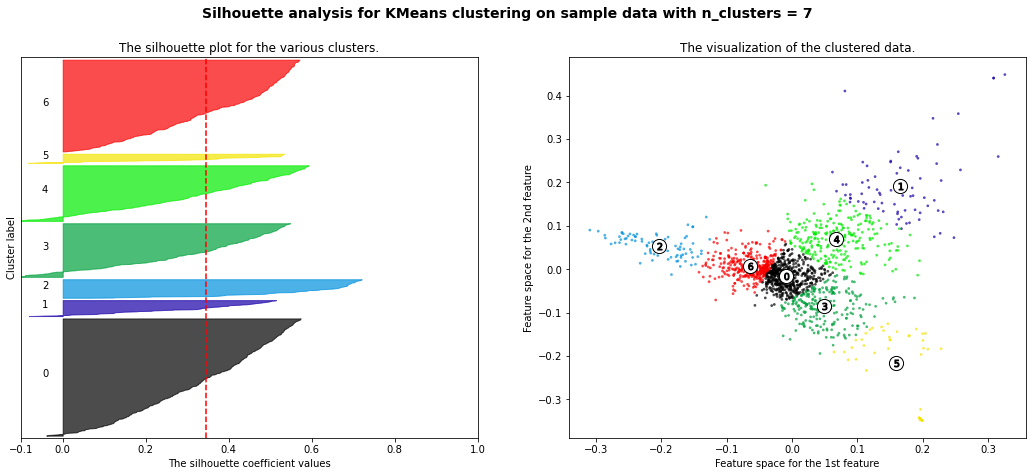

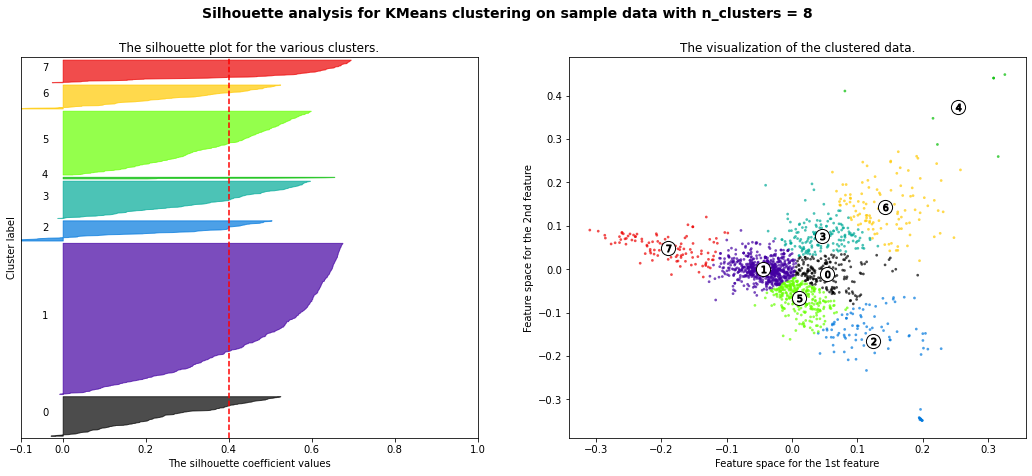

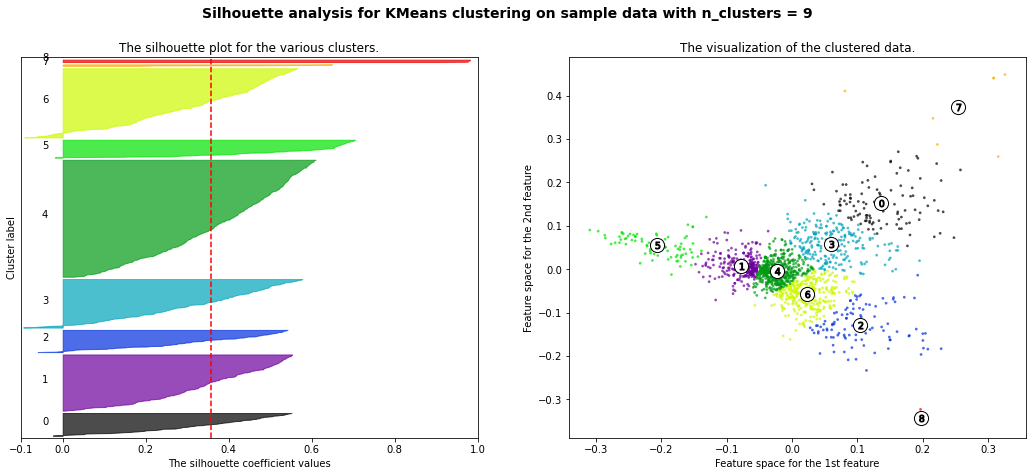

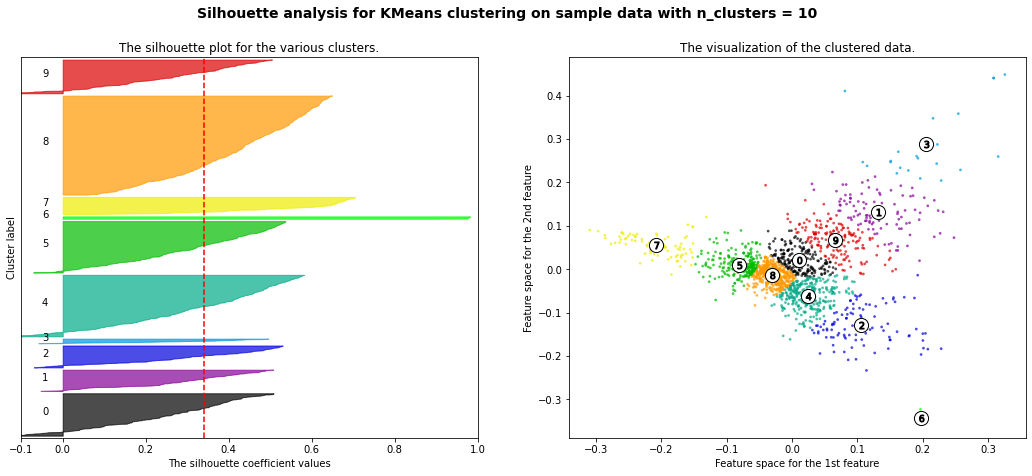

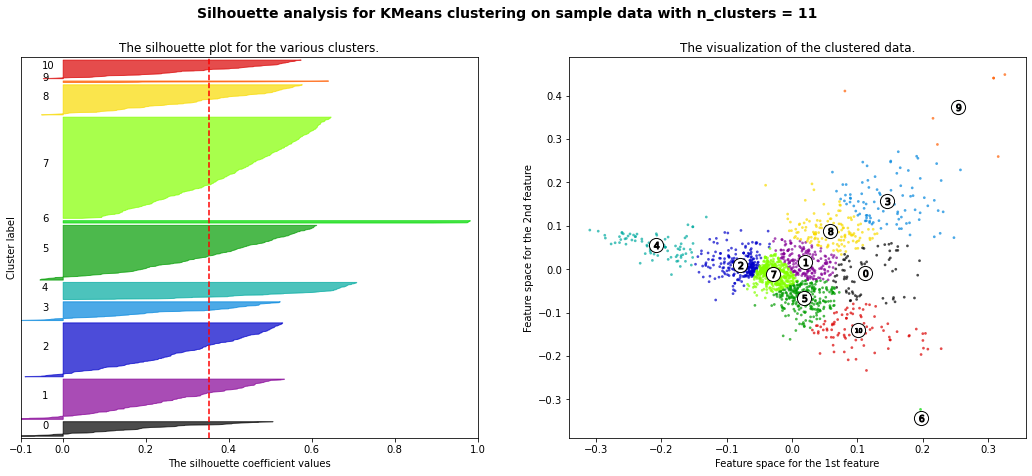

In [4]:

range_n_clusters = range(7, 12)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print()
    print()
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
       
    print()

    get_top_keywords(X_idf.todense(), cluster_labels, vectorizer.get_feature_names(), 10)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
          

plt.show()